In [4]:
from src.inference.motif_finding.motif_addition import add_motifs
import scipy.stats as stats
import numpy as np
import pandas as pd

tsv_file = "/data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding/src/inference/motif_finding/validation_combined_AR_22Rv1.csv"            # The TSV file with regions
reference_genome = "/data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding/data/genome.fa"      # The reference genome file (FASTA format)
jaspar_file = "/data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding/src/inference/motif_finding/motif.jaspar"      # The motif file (JASPAR format)
output_file = "./validation_combined.csv"  # Output TSV file with motif column
# df = add_motifs(tsv_file, jaspar_file, reference_genome, output_file, percentile_cutoff=0) 
all_motifs_df, best_motifs_df, top10_motifs_df = add_motifs(tsv_file, jaspar_file, reference_genome, output_file, min_score=-10, top_n=2)

2024-12-04 15:49:01,101 - INFO - Reading motif from JASPAR file: /data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding/src/inference/motif_finding/motif.jaspar
2024-12-04 15:49:01,114 - INFO - Motif length: 15
2024-12-04 15:49:01,115 - INFO - Opening reference genome FASTA file: /data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding/data/genome.fa
2024-12-04 15:49:01,156 - INFO - Reading input TSV file: /data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding/src/inference/motif_finding/validation_combined_AR_22Rv1.csv
2024-12-04 15:49:01,384 - INFO - Starting motif processing...
Processing motifs: 100%|██████████| 103209/103209 [04:51<00:00, 354.59it/s]
2024-12-04 15:54:04,434 - INFO - Percentile threshold (0%): -10.0
2024-12-04 15:54:05,567 - INFO - Best motifs saved to: ./validation_combined.csv


In [27]:
# aggregate the top 10 motifs
top10_motifs_df['motif_score'] = top10_motifs_df['motif_score'].astype(str)
top10_motifs_df_agg = top10_motifs_df.groupby(['chr', 'start', 'end', 'count', 'label', 'cell_line']).agg({'motif_sequence': ','.join, 'motif_score': ','.join}).reset_index()

# compare len of motif sequences (number of motifs in it) between 1 and 0 labels if no_motif its a 0
top10_motifs_df_agg['motif_count'] = top10_motifs_df_agg['motif_sequence'].apply(lambda x: len(x.split(',')) if x != 'no_motif' else 0)
top10_motifs_df_agg

# compare motif count between 1 and 0 labels
print(top10_motifs_df_agg[top10_motifs_df_agg['label'] == 1]['motif_count'].mean())
print(top10_motifs_df_agg[top10_motifs_df_agg['label'] == 0]['motif_count'].mean())


1.9923134608173978
1.9995095785440613


Number of NAs in motif_score: 0
Mann-Whitney U test statistic: 255509554.5
p-value: 0.023722905893917928

Mean motif score for ChIP-seq positive regions: 7.8359
Mean motif score for ChIP-seq negative regions: nan


/data1/home/wjarrard/miniconda3/envs/processing/lib/python3.10/site-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/data1/home/wjarrard/miniconda3/envs/processing/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/data1/home/wjarrard/miniconda3/envs/processing/lib/python3.10/site-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan


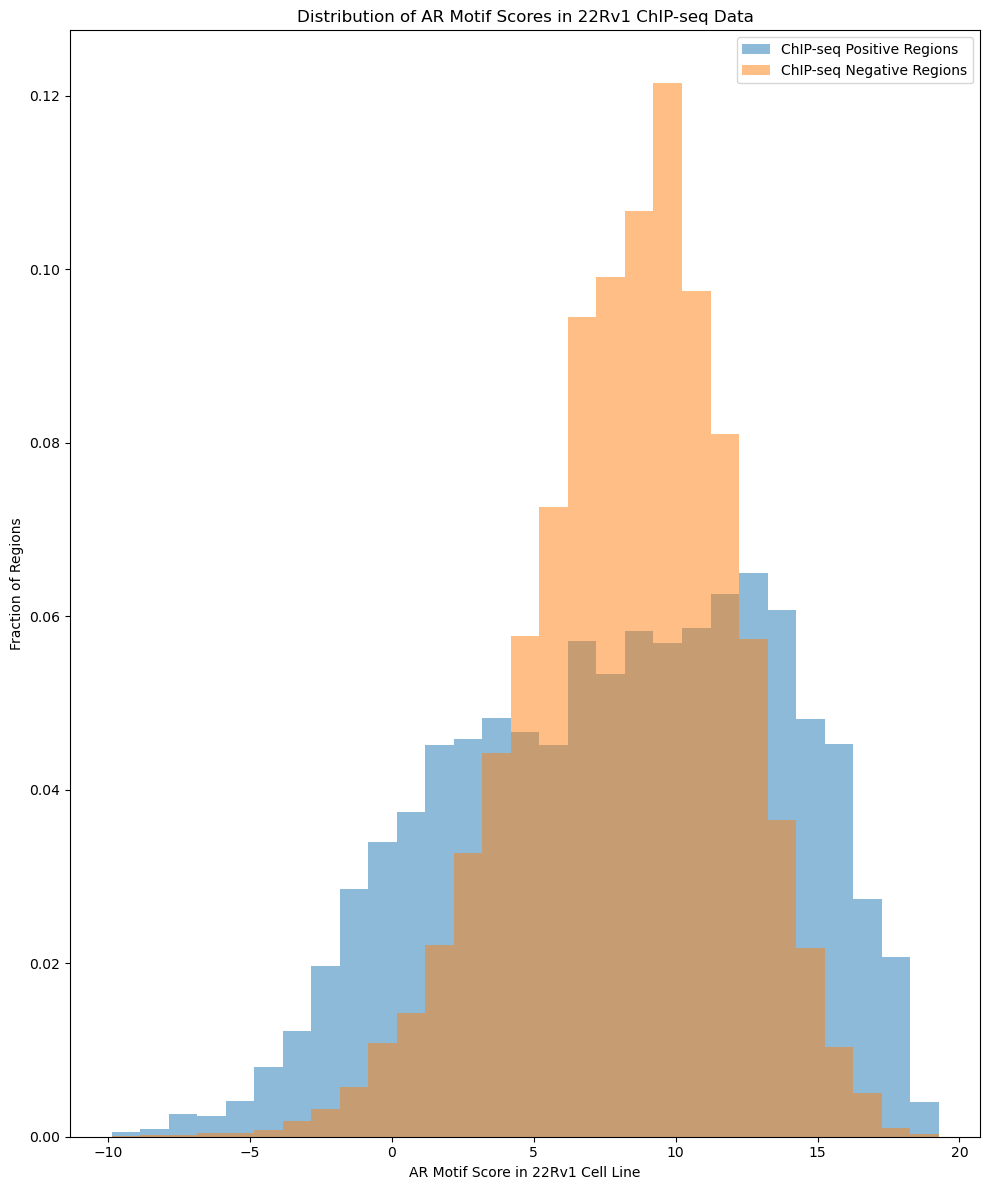

In [6]:
df = best_motifs_df
# drop nas
# count nas
print("Number of NAs in motif_score:", df['motif_score'].isna().sum())

df = df.dropna()
# get distribution of motif scores label 1 vs label 0
df['motif_score'].value_counts()

# Separate the data into two groups based on the label
positive_hits = df[df['label'] == 1]['motif_score']  # ChIP-seq positive regions
negative_hits = df[df['label'] == 0]['motif_score']  # ChIP-seq negative regions

# Remove 'NaN' values and convert to numeric, also remove infinite values
positive_hits = pd.to_numeric(positive_hits[positive_hits != 'NA'], errors='coerce')
negative_hits = pd.to_numeric(negative_hits[negative_hits != 'NA'], errors='coerce')

# Remove infinite values
positive_hits = positive_hits[~np.isinf(positive_hits)]
negative_hits = negative_hits[~np.isinf(negative_hits)]

# Perform a Mann-Whitney U test
statistic, p_value = stats.mannwhitneyu(positive_hits, negative_hits, alternative='two-sided')

print(f"Mann-Whitney U test statistic: {statistic}")
print(f"p-value: {p_value}")

# Calculate and print the mean scores for each group
mean_score_positive = positive_hits.mean()
mean_score_negative = negative_hits.mean()

print(f"\nMean motif score for ChIP-seq positive regions: {mean_score_positive:.4f}")
print(f"Mean motif score for ChIP-seq negative regions: {mean_score_negative:.4f}")

import matplotlib.pyplot as plt

# Create figure
fig, (ax2) = plt.subplots(1, 1, figsize=(10, 12))

# Plot normalized histograms
weights_pos = np.ones_like(positive_hits) / len(positive_hits)
weights_neg = np.ones_like(negative_hits) / len(negative_hits)

# Calculate range for histogram bins
min_val = min(positive_hits.min(), negative_hits.min())
max_val = max(positive_hits.max(), negative_hits.max())
bins = np.linspace(min_val, max_val, 30)

ax2.hist(positive_hits, bins=bins, alpha=0.5, label='ChIP-seq Positive Regions', weights=weights_pos)
ax2.hist(negative_hits, bins=bins, alpha=0.5, label='ChIP-seq Negative Regions', weights=weights_neg)
ax2.set_xlabel('AR Motif Score in 22Rv1 Cell Line')
ax2.set_ylabel('Fraction of Regions')
ax2.set_title('Distribution of AR Motif Scores in 22Rv1 ChIP-seq Data')
ax2.legend()

plt.tight_layout()
plt.show()


In [13]:
# get the motifs with a score greater than 15
df[df['motif_score'] > 15]['motif_sequence'].value_counts()

threshold = 14

# get true positives false positives, true negatives, false negatives
true_positives = df[(df['label'] == 1) & (df['motif_score'] > threshold)]
false_positives = df[(df['label'] == 0) & (df['motif_score'] > threshold)]
true_negatives = df[(df['label'] == 0) & (df['motif_score'] <= threshold)]
false_negatives = df[(df['label'] == 1) & (df['motif_score'] <= threshold)]

print("true positives: ", len(true_positives))
print("false positives: ", len(false_positives))
print("true negatives: ", len(true_negatives))
print("false negatives: ", len(false_negatives))



true positives:  815
false positives:  4429
true negatives:  93446
false negatives:  4519


In [35]:
df[df['label'] == 1]['motif_sequence'].value_counts()


motif_sequence
AGGAACAGTCAGCAG    20
GAGTAAACAGACAAC    13
ATGGAATGGAATGGA     6
TAGCCCTAAATCCAT     5
GAGGAGATCAAGACC     5
                   ..
CTTTCTCAAACAAAA     1
CCGACCCAATTAAAT     1
AAGGACATTTGGTAC     1
GTATGAAAAGGTTTT     1
TGGAAAGCAATGGAC     1
Name: count, Length: 5165, dtype: int64

In [36]:
# see what motifs differ most in count between label 1 and label 0
df[df['motif_sequence'] != 'no_motif']['motif_sequence'].value_counts()
df[df['label'] == 1]['motif_sequence'].value_counts()
df[df['label'] == 0]['motif_sequence'].value_counts()

# see what the biggest differences 

motif_sequence
GGGAACTCCCTGACC    672
CCCTTGCGCTTCCCA    352
TGCCTCCTCAAGTGG    120
CCCTTGCGCTTCCCG     79
CAGCACTCTGTGTCT     69
                  ... 
AGGAACTTACAGTTC      1
GAGAACTTTTGGTAC      1
AAAATATTTGACTGT      1
GGGCACAGTGGGAAA      1
TGGAACTGAATGGAC      1
Name: count, Length: 89122, dtype: int64